# XGBoost : Base Model

**=====Imports=====**

In [2]:

import warnings
warnings.filterwarnings("ignore")

import os
from pathlib import Path
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.dpi'] = 100

print("✅ Libraries loaded")

✅ Libraries loaded


**=====Helper Functions=====**

In [3]:
def mape(y_true, y_pred):
    """Mean Absolute Percentage Error"""
    denom = np.where(np.abs(y_true) < 1e-6, 1e-6, y_true)
    return np.mean(np.abs((y_true - y_pred) / denom)) * 100

def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    num = np.abs(y_pred - y_true)
    denom = (np.abs(y_true) + np.abs(y_pred)) / 2.0
    denom = np.where(denom == 0, 1e-6, denom)
    return np.mean(num / denom) * 100

print("✅ Helper functions defined")

✅ Helper functions defined


**=====Configuration=====**

In [4]:
# ===== CONFIGURATION =====

# Auto-detect project paths
current_dir = Path.cwd()
if 'Model_Training' in str(current_dir):
    project_root = current_dir.parent.parent
else:
    project_root = current_dir

# Define paths
MERGE_DIR = project_root / "Merge_Dataset"
BASE_CSV = MERGE_DIR / "Base_Dataset_clipped_Target.csv"
MODELS_DIR = project_root / "Models Result"

# Create directories if needed
MODELS_DIR.mkdir(exist_ok=True)

# Training configuration
CUT_OFF_YEAR = 2018
RANDOM_STATE = 42

print(f"📁 Project root: {project_root}")
print(f"📁 Using dataset: {BASE_CSV.name}")
print("✅ Configuration loaded")

📁 Project root: c:\FYP Finding\Inflation_Forecasting
📁 Using dataset: Base_Dataset_clipped_Target.csv
✅ Configuration loaded


**=====Feature Configuration=====**

In [5]:
# Feature definitions
numeric_features = ["GDP", "Exchange_Rate", "Interest_Rate", "Unemployment_Rate"]
categorical_features = ["Country"]
TARGET = "Inflation_next"

print(f"Features: {len(numeric_features)} numeric + {len(categorical_features)} categorical")
print(f"Target: {TARGET}")

Features: 4 numeric + 1 categorical
Target: Inflation_next


**=====Load Dataset=====**

In [6]:
# === Load dataset ===
df = pd.read_csv(BASE_CSV)

print(f"Dataset loaded: {df.shape[0]} rows × {df.shape[1]} columns")
print(f"Period: {df['Year'].min()} - {df['Year'].max()}")
print(f"Countries: {df['Country'].nunique()}")

Dataset loaded: 11594 rows × 8 columns
Period: 1990 - 2023
Countries: 341


**=====Train/Test Split=====**

In [7]:
# ============================================================
#                    TRAIN/TEST SPLIT
# ============================================================

# Time-based split
train_df = df[df["Year"] <= CUT_OFF_YEAR].copy()
test_df = df[df["Year"] > CUT_OFF_YEAR].copy()

# Remove missing targets
train_df = train_df.dropna(subset=[TARGET])
test_df = test_df.dropna(subset=[TARGET])

print(f"Train shape: {train_df.shape}")
print(f"Test shape:  {test_df.shape}")
print(f"Train years: {train_df['Year'].min()} to {train_df['Year'].max()}")
print(f"Test years:  {test_df['Year'].min()} to {test_df['Year'].max()}")
print(f"Train countries: {train_df['Country'].nunique()}")
print(f"Test countries:  {test_df['Country'].nunique()}")

# Prepare features and target
X_train = train_df[numeric_features + categorical_features]
y_train = train_df[TARGET]
X_test = test_df[numeric_features + categorical_features]
y_test = test_df[TARGET]

print("\n=== Final Shapes ===")
print(f"X_train: {X_train.shape} | y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}  | y_test:  {y_test.shape}")
print("\n✅ Train/test split completed successfully!")

Train shape: (9889, 8)
Test shape:  (1705, 8)
Train years: 1990 to 2018
Test years:  2019 to 2023
Train countries: 341
Test countries:  341

=== Final Shapes ===
X_train: (9889, 5) | y_train: (9889,)
X_test:  (1705, 5)  | y_test:  (1705,)

✅ Train/test split completed successfully!


**=====Preprocessing Pipeline=====**

In [8]:
# === Build Pipeline ===

# OneHotEncoder
try:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown="ignore", sparse=False)

# Preprocessing
preprocessor = ColumnTransformer([
    ("num", Pipeline([
        ("imputer", SimpleImputer(strategy="median")),
        ("scaler", StandardScaler())
    ]), numeric_features),
    ("cat", Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("ohe", ohe)
    ]), categorical_features)
])

# Full pipeline with XGBoost
pipe = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(random_state=RANDOM_STATE, n_jobs=-1, verbosity=0))
])

print("✅ Pipeline created")

✅ Pipeline created


**=====Train Default Model=====**

In [9]:
# ======================================================================
#                TRAIN DEFAULT (UNTUNED) BASELINE
# ======================================================================

print("\n" + "="*70)
print("    TRAINING WITH DEFAULT PARAMETERS (BASELINE)")
print("="*70)

import time

# Create pipeline with DEFAULT XGBoost parameters
pipe_default = Pipeline([
    ("preprocessor", preprocessor),
    ("model", XGBRegressor(
        random_state=RANDOM_STATE,
        n_jobs=-1,
        verbosity=0
        # XGBoost defaults:
        # n_estimators=100
        # max_depth=6
        # learning_rate=0.3
        # subsample=1.0
        # colsample_bytree=1.0
    ))
])

print("\n📋 Default XGBoost Parameters:")
print("   n_estimators:      100")
print("   max_depth:         6")
print("   learning_rate:     0.3")
print("   subsample:         1.0")
print("   colsample_bytree:  1.0")

# Train default model
print("\n⏱️  Training default model...")
start_default = time.time()
pipe_default.fit(X_train, y_train)
time_default = time.time() - start_default

# Predict on test set
y_pred_default = pipe_default.predict(X_test)

# Calculate metrics
mae_default = mean_absolute_error(y_test, y_pred_default)
rmse_default = np.sqrt(mean_squared_error(y_test, y_pred_default))
r2_default = r2_score(y_test, y_pred_default)
mape_default = mape(y_test.values, y_pred_default)
smape_default = smape(y_test.values, y_pred_default)

print(f"\n✅ Default Model Performance (Untuned):")
print(f"   Training time: {time_default/60:.1f} minutes")
print(f"   MAE:    {mae_default:.4f}")
print(f"   RMSE:   {rmse_default:.4f}")
print(f"   R²:     {r2_default:.4f}")
print(f"   MAPE:   {mape_default:.2f}%")
print(f"   SMAPE:  {smape_default:.2f}%")

print("="*70)


    TRAINING WITH DEFAULT PARAMETERS (BASELINE)

📋 Default XGBoost Parameters:
   n_estimators:      100
   max_depth:         6
   learning_rate:     0.3
   subsample:         1.0
   colsample_bytree:  1.0

⏱️  Training default model...

✅ Default Model Performance (Untuned):
   Training time: 0.0 minutes
   MAE:    4.6340
   RMSE:   12.4198
   R²:     0.2632
   MAPE:   172.67%
   SMAPE:  55.84%


**=====Hyperparameter Tuning=====**

In [10]:
# ============================================================
#             HYPERPARAMETER TUNING (GRID SEARCH)
# ============================================================

print("\n" + "="*70)
print("    HYPERPARAMETER TUNING WITH GRIDSEARCHCV")
print("="*70)

# Parameter grid for XGBoost_Base (simpler model - 4 features only)
param_grid = {
    "model__n_estimators": [100, 200, 300],
    "model__max_depth": [6, 10, 15],
    "model__learning_rate": [0.1, 0.2, 0.3]
}

total_combinations = np.prod([len(v) for v in param_grid.values()])
cv_folds = 3
total_fits = total_combinations * cv_folds

print(f"\n📊 Grid Search Configuration:")
print(f"   Hyperparameter combinations: {total_combinations}")
print(f"   Cross-validation folds:      {cv_folds}")
print(f"   Total model fits:            {total_fits}")
print(f"   Scoring metric:              neg_mean_absolute_error")
print(f"   Features: {len(numeric_features)} (BASE FEATURES ONLY)")

# Grid search
print(f"\n⏱️  Starting GridSearchCV...")
start_gs = time.time()

gs = GridSearchCV(
    pipe,
    param_grid, 
    cv=cv_folds,
    scoring="neg_mean_absolute_error", 
    n_jobs=-1,
    verbose=2
)

gs.fit(X_train, y_train)

time_gs = time.time() - start_gs

# Results
print("\n" + "="*70)
print("    GRID SEARCH COMPLETED!")
print("="*70)
print(f"⏱️  Training time: {time_gs/60:.1f} minutes")
print(f"\n🎯 Best Parameters Found:")
for param, value in gs.best_params_.items():
    print(f"   {param}: {value}")
print(f"\n✅ Best CV score (neg MAE): {-gs.best_score_:.4f}")

best_model = gs.best_estimator_

print("="*70)


    HYPERPARAMETER TUNING WITH GRIDSEARCHCV

📊 Grid Search Configuration:
   Hyperparameter combinations: 27
   Cross-validation folds:      3
   Total model fits:            81
   Scoring metric:              neg_mean_absolute_error
   Features: 4 (BASE FEATURES ONLY)

⏱️  Starting GridSearchCV...
Fitting 3 folds for each of 27 candidates, totalling 81 fits

    GRID SEARCH COMPLETED!
⏱️  Training time: 1.6 minutes

🎯 Best Parameters Found:
   model__learning_rate: 0.1
   model__max_depth: 6
   model__n_estimators: 300

✅ Best CV score (neg MAE): 5.3796


**=====Generate Predictions=====**

In [11]:
# === Generate Predictions ===

# Model predictions
y_pred = best_model.predict(X_test)

# Baseline 1: Persistence (predict current inflation = next inflation)
y_pred_persist = test_df["Inflation"].values

# Baseline 2: Mean (predict training average for all test cases)
y_pred_mean = np.full(len(y_test), train_df[TARGET].mean())

print("✅ Predictions generated")

✅ Predictions generated


**=====Calculate Metrics=====**

In [12]:
# === Calculate Metrics ===

# XGBoost Base metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape_val = mape(y_test.values, y_pred)
smape_val = smape(y_test.values, y_pred)

# Persistence metrics
mae_p = mean_absolute_error(y_test, y_pred_persist)
rmse_p = np.sqrt(mean_squared_error(y_test, y_pred_persist))
r2_p = r2_score(y_test, y_pred_persist)
mape_p = mape(y_test.values, y_pred_persist)
smape_p = smape(y_test.values, y_pred_persist)

# Mean metrics
mae_m = mean_absolute_error(y_test, y_pred_mean)
rmse_m = np.sqrt(mean_squared_error(y_test, y_pred_mean))
r2_m = r2_score(y_test, y_pred_mean)
mape_m = mape(y_test.values, y_pred_mean)
smape_m = smape(y_test.values, y_pred_mean)

print("✅ Metrics calculated")

✅ Metrics calculated


**=====Compare Default VS Tuned=====**


    DEFAULT vs TUNED MODEL COMPARISON

📊 Performance Comparison:


,Version,MAE,RMSE,R²,MAPE%,SMAPE%,Training Time (min)
0,Default (Untuned),4.6340,12.4198,0.2632,172.67,55.84,0.0
1,Tuned (GridSearchCV),4.6672,12.6222,0.2390,195.72,54.31,1.6



    KEY IMPROVEMENTS FROM HYPERPARAMETER TUNING

📈 Performance Gains:
   MAE:  4.6340 → 4.6672  (Δ = -0.0332, -0.72%)
   RMSE: 12.4198 → 12.6222  (Δ = -0.2024, -1.63%)
   R²:   0.2632 → 0.2390  (Δ = -0.0242, -9.20%)

🎯 Hyperparameters Changed:
   Parameter                      Default         Tuned           Change
   ---------------------------------------------------------------------------
   learning_rate                  0.3             0.1             0.3 → 0.1
   max_depth                      6               6               Same
   n_estimators                   100             300             100 → 300

⏱️  Training Time:
   Default:  0.0 minutes
   Tuned:    1.6 minutes
   Increase: +6336.6%


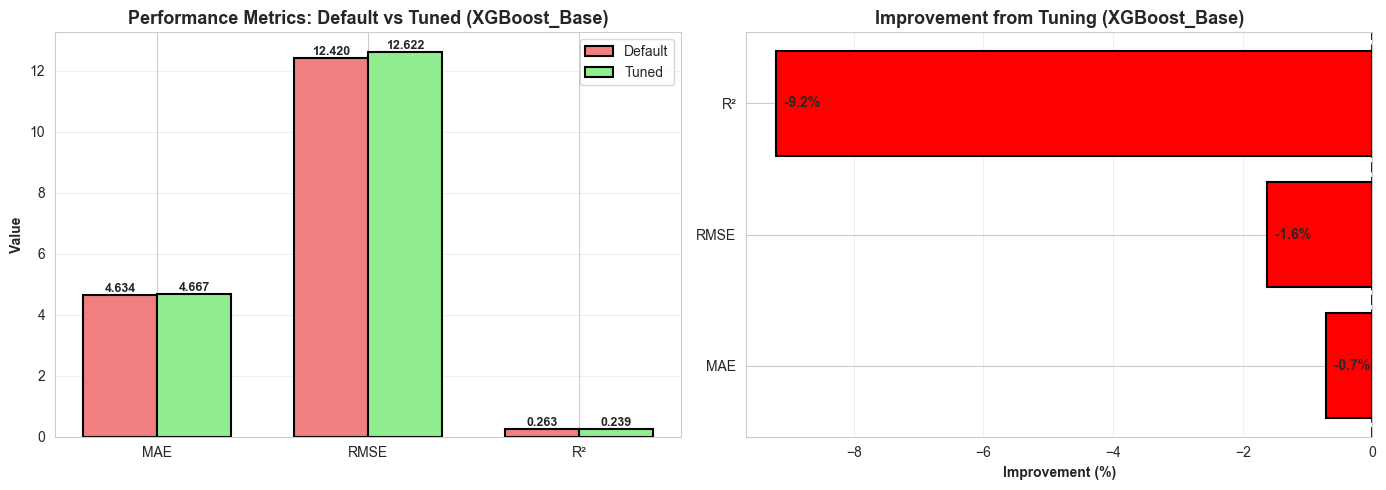


✅ CONCLUSION:
   Hyperparameter tuning WORSENED performance
   RMSE changed by -1.63%, R² changed by -9.20%
   ⚠️  DEFAULT MODEL PERFORMS BETTER - consider using default parameters
   GridSearchCV completed for XGBoost_Base


In [13]:
# ======================================================================
#        HYPERPARAMETER TUNING IMPACT ANALYSIS
# ======================================================================

print("\n" + "="*70)
print("    DEFAULT vs TUNED MODEL COMPARISON")
print("="*70)

# Create comparison DataFrame
tuning_comparison = pd.DataFrame({
    'Version': ['Default (Untuned)', 'Tuned (GridSearchCV)'],
    'MAE': [mae_default, mae],
    'RMSE': [rmse_default, rmse],
    'R²': [r2_default, r2],
    'MAPE%': [mape_default, mape_val],
    'SMAPE%': [smape_default, smape_val],
    'Training Time (min)': [time_default/60, time_gs/60]
})

# Calculate improvements
mae_improvement = mae_default - mae
rmse_improvement = rmse_default - rmse
r2_improvement = r2 - r2_default

mae_improvement_pct = (mae_improvement / mae_default) * 100
rmse_improvement_pct = (rmse_improvement / rmse_default) * 100
r2_improvement_pct = (r2_improvement / abs(r2_default)) * 100 if r2_default != 0 else 0

print("\n📊 Performance Comparison:")
display(tuning_comparison.style.format({
    'MAE': '{:.4f}',
    'RMSE': '{:.4f}',
    'R²': '{:.4f}',
    'MAPE%': '{:.2f}',
    'SMAPE%': '{:.2f}',
    'Training Time (min)': '{:.1f}'
}).background_gradient(subset=['MAE', 'RMSE', 'R²'], cmap='RdYlGn_r'))

print("\n" + "="*70)
print("    KEY IMPROVEMENTS FROM HYPERPARAMETER TUNING")
print("="*70)

print(f"\n📈 Performance Gains:")
print(f"   MAE:  {mae_default:.4f} → {mae:.4f}  (Δ = {mae_improvement:.4f}, {mae_improvement_pct:+.2f}%)")
print(f"   RMSE: {rmse_default:.4f} → {rmse:.4f}  (Δ = {rmse_improvement:.4f}, {rmse_improvement_pct:+.2f}%)")
print(f"   R²:   {r2_default:.4f} → {r2:.4f}  (Δ = {r2_improvement:.4f}, {r2_improvement_pct:+.2f}%)")

print(f"\n🎯 Hyperparameters Changed:")
print(f"   {'Parameter':<30} {'Default':<15} {'Tuned':<15} {'Change'}")
print(f"   {'-'*75}")

default_params = {
    'n_estimators': 100,
    'max_depth': 6,
    'learning_rate': 0.3,
    'subsample': 1.0,
    'colsample_bytree': 1.0
}

for param_full, tuned_value in gs.best_params_.items():
    param_short = param_full.replace('model__', '')
    default_value = default_params.get(param_short, 'N/A')
    
    if str(default_value) == str(tuned_value):
        change = "Same"
    else:
        change = f"{default_value} → {tuned_value}"
    
    print(f"   {param_short:<30} {str(default_value):<15} {str(tuned_value):<15} {change}")

print(f"\n⏱️  Training Time:")
print(f"   Default:  {time_default/60:.1f} minutes")
print(f"   Tuned:    {time_gs/60:.1f} minutes")
print(f"   Increase: {((time_gs - time_default) / time_default * 100):+.1f}%")

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Metrics Comparison
ax1 = axes[0]
metrics = ['MAE', 'RMSE', 'R²']
default_vals = [mae_default, rmse_default, r2_default]
tuned_vals = [mae, rmse, r2]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax1.bar(x - width/2, default_vals, width, label='Default', 
                color='lightcoral', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, tuned_vals, width, label='Tuned', 
                color='lightgreen', edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Value', fontweight='bold')
ax1.set_title('Performance Metrics: Default vs Tuned (XGBoost_Base)', 
              fontweight='bold', fontsize=13)
ax1.set_xticks(x)
ax1.set_xticklabels(metrics)
ax1.legend()
ax1.grid(alpha=0.3, axis='y')

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', 
                fontsize=9, fontweight='bold')

# Plot 2: Improvement Percentages
ax2 = axes[1]
improvements = [mae_improvement_pct, rmse_improvement_pct, r2_improvement_pct]
colors = ['green' if x > 0 else 'red' for x in improvements]

bars = ax2.barh(metrics, improvements, color=colors, edgecolor='black', linewidth=1.5)
ax2.axvline(x=0, color='black', linestyle='--', linewidth=2)
ax2.set_xlabel('Improvement (%)', fontweight='bold')
ax2.set_title('Improvement from Tuning (XGBoost_Base)', fontweight='bold', fontsize=13)
ax2.grid(alpha=0.3, axis='x')

# Add value labels
for bar, val in zip(bars, improvements):
    ax2.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
            f'  {val:+.1f}%', va='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*70)
print("✅ CONCLUSION:")
if rmse_improvement_pct > 5:
    print(f"   Hyperparameter tuning provided SIGNIFICANT improvement")
    print(f"   RMSE improved by {rmse_improvement_pct:.2f}%, R² improved by {r2_improvement_pct:.2f}%")
elif rmse_improvement_pct > 2:
    print(f"   Hyperparameter tuning provided MODERATE improvement")
    print(f"   RMSE improved by {rmse_improvement_pct:.2f}%, R² improved by {r2_improvement_pct:.2f}%")
elif rmse_improvement_pct > 0:
    print(f"   Hyperparameter tuning provided MINOR improvement")
    print(f"   RMSE improved by {rmse_improvement_pct:.2f}%, R² improved by {r2_improvement_pct:.2f}%")
else:
    print(f"   Hyperparameter tuning WORSENED performance")
    print(f"   RMSE changed by {rmse_improvement_pct:.2f}%, R² changed by {r2_improvement_pct:.2f}%")
    print(f"   ⚠️  DEFAULT MODEL PERFORMS BETTER - consider using default parameters")

print(f"   GridSearchCV completed for XGBoost_Base")
print("="*70)

**=====Model Comparison=====**

In [14]:
# ======================================================================
#                     TEST SET PERFORMANCE
# ======================================================================

# Enhanced comparison including default
comparison = pd.DataFrame({
    "Model": ["Persistence", "Mean Baseline", "XGBoost Base (Default)", "XGBoost Base (Tuned)"],
    "MAE ↓": [mae_p, mae_m, mae_default, mae],
    "RMSE ↓": [rmse_p, rmse_m, rmse_default, rmse],
    "R² ↑": [r2_p, r2_m, r2_default, r2],
    "MAPE% ↓": [mape_p, mape_m, mape_default, mape_val],
    "SMAPE% ↓": [smape_p, smape_m, smape_default, smape_val]
})

# Highlight best
def highlight_best(s):
    if s.name in ['MAE ↓', 'RMSE ↓', 'MAPE% ↓', 'SMAPE% ↓']:
        is_best = s == s.min()
    else:
        is_best = s == s.max()
    return ['background-color: lightgreen; font-weight: bold' if v else '' for v in is_best]

display(comparison.style.apply(highlight_best, subset=comparison.columns[1:], axis=0))

# ======================================================================
#            XGBOOST BASE IMPROVEMENT ANALYSIS
# ======================================================================

print("\n" + "="*70)
print("    IMPROVEMENT OVER BASELINES")
print("="*70)

print(f"\n📊 XGBoost Base (Tuned) vs Baselines:")
print(f"   MAE improvement over Persistence:   {((mae_p - mae) / mae_p * 100):+.2f}%")
print(f"   MAE improvement over Mean:          {((mae_m - mae) / mae_m * 100):+.2f}%")
print(f"   RMSE improvement over Persistence:  {((rmse_p - rmse) / rmse_p * 100):+.2f}%")
print(f"   RMSE improvement over Mean:         {((rmse_m - rmse) / rmse_m * 100):+.2f}%")

print(f"\n📊 XGBoost Base (Tuned) vs Default:")
print(f"   MAE improvement:   {((mae_default - mae) / mae_default * 100):+.2f}%")
print(f"   RMSE improvement:  {((rmse_default - rmse) / rmse_default * 100):+.2f}%")
print(f"   R² improvement:    {((r2 - r2_default) / abs(r2_default) * 100):+.2f}%")

print("="*70)

,Model,MAE ↓,RMSE ↓,R² ↑,MAPE% ↓,SMAPE% ↓
0,Persistence,3.288351,15.992654,-0.221741,83.848257,46.177027
1,Mean Baseline,6.041782,14.498332,-0.004093,362.175969,75.421825
2,XGBoost Base (Default),4.634004,12.419843,0.263165,172.672311,55.842619
3,XGBoost Base (Tuned),4.667203,12.622231,0.238955,195.722853,54.312202



    IMPROVEMENT OVER BASELINES

📊 XGBoost Base (Tuned) vs Baselines:
   MAE improvement over Persistence:   -41.93%
   MAE improvement over Mean:          +22.75%
   RMSE improvement over Persistence:  +21.07%
   RMSE improvement over Mean:         +12.94%

📊 XGBoost Base (Tuned) vs Default:
   MAE improvement:   -0.72%
   RMSE improvement:  -1.63%
   R² improvement:    -9.20%


**=====Error Analysis=====**

In [15]:
# ======================================================================
#                       ERROR ANALYSIS
# ======================================================================

residuals = y_test.values - y_pred
large_errors = np.abs(residuals) > 10

print(f"Residuals: Mean={residuals.mean():.4f}, Std={residuals.std():.4f}")
print(f"Large errors (>10pp): {large_errors.sum()} / {len(residuals)} ({100*large_errors.mean():.1f}%)")

# Worst predictions
worst_idx = np.argsort(np.abs(residuals))[-10:]
worst_predictions = pd.DataFrame({
    'Country': test_df.iloc[worst_idx]['Country'].values,
    'Year': test_df.iloc[worst_idx]['Year'].values,
    'Actual': y_test.values[worst_idx],
    'Predicted': y_pred[worst_idx],
    'Error': residuals[worst_idx],
    'AbsError': np.abs(residuals[worst_idx])
}).sort_values('AbsError', ascending=False)

print("\n=== Top 10 Worst Predictions ===")
display(worst_predictions)

Residuals: Mean=-0.6925, Std=12.6032
Large errors (>10pp): 144 / 1705 (8.4%)

=== Top 10 Worst Predictions ===


,Country,Year,Actual,Predicted,Error,AbsError
9,South Sudan,2021,-1.562904,113.694359,-115.257263,115.257263
8,Moldova,2022,13.417010,126.818321,-113.401311,113.401311
7,Moldova,2023,4.677735,112.859032,-108.181297,108.181297
6,Lebanon,2020,136.902828,32.813129,104.089698,104.089698
5,"Venezuela, RB",2021,136.902828,38.250813,98.652015,98.652015
4,Lebanon,2021,136.902828,40.815891,96.086936,96.086936
3,Lebanon,2022,136.902828,42.348015,94.554813,94.554813
2,Sudan,2020,136.902828,50.118977,86.783851,86.783851
1,Sudan,2022,136.902828,51.221500,85.681327,85.681327
0,Iraq,2022,4.358354,87.952263,-83.593909,83.593909


**=====Visualizations=====**

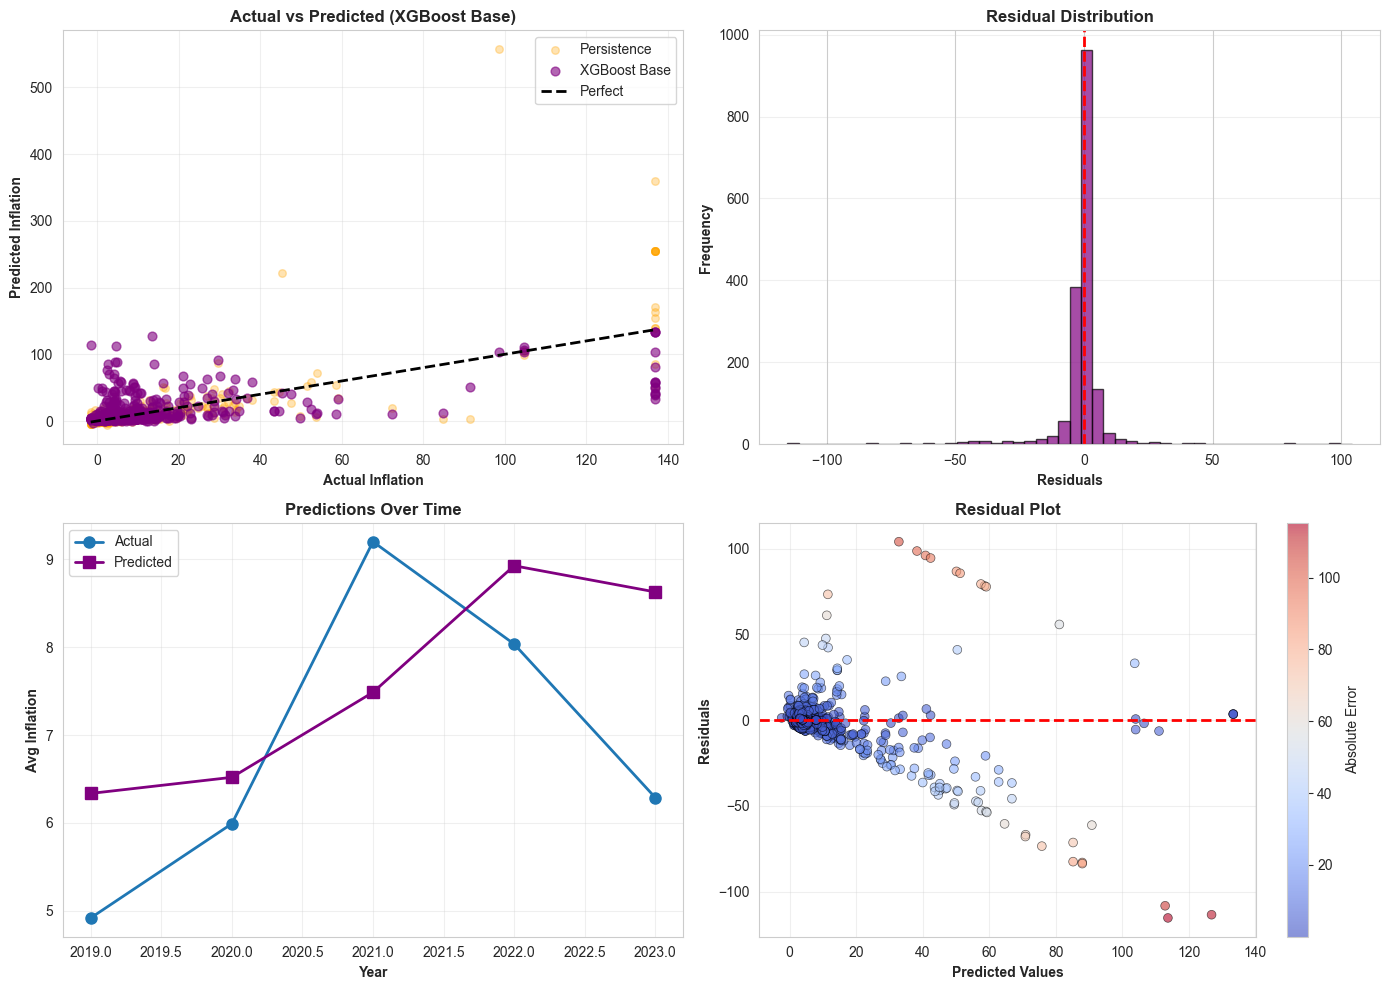

In [16]:
# === Visualizations ===
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: Actual vs Predicted
ax1 = axes[0, 0]
ax1.scatter(y_test, y_pred_persist, alpha=0.3, s=30, label='Persistence', color='orange')
ax1.scatter(y_test, y_pred, alpha=0.6, s=40, label='XGBoost Base', color='purple')
lims = [y_test.min(), y_test.max()]
ax1.plot(lims, lims, 'k--', lw=2, label='Perfect')
ax1.set_xlabel('Actual Inflation', fontweight='bold')
ax1.set_ylabel('Predicted Inflation', fontweight='bold')
ax1.set_title('Actual vs Predicted (XGBoost Base)', fontweight='bold', fontsize=12)
ax1.legend()
ax1.grid(alpha=0.3)

# Plot 2: Residuals Distribution
ax2 = axes[0, 1]
ax2.hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='purple')
ax2.axvline(0, color='red', linestyle='--', lw=2)
ax2.set_xlabel('Residuals', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')
ax2.set_title('Residual Distribution', fontweight='bold', fontsize=12)
ax2.grid(alpha=0.3, axis='y')

# Plot 3: Predictions Over Time
ax3 = axes[1, 0]
yearly = pd.DataFrame({
    'Year': test_df['Year'],
    'Actual': y_test.values,
    'Predicted': y_pred
}).groupby('Year').mean()
ax3.plot(yearly.index, yearly['Actual'], 'o-', label='Actual', lw=2, markersize=8)
ax3.plot(yearly.index, yearly['Predicted'], 's-', label='Predicted', lw=2, markersize=8, color='purple')
ax3.set_xlabel('Year', fontweight='bold')
ax3.set_ylabel('Avg Inflation', fontweight='bold')
ax3.set_title('Predictions Over Time', fontweight='bold', fontsize=12)
ax3.legend()
ax3.grid(alpha=0.3)

# Plot 4: Residuals vs Predicted
ax4 = axes[1, 1]
scatter = ax4.scatter(y_pred, residuals, c=np.abs(residuals), 
                      cmap='coolwarm', s=40, alpha=0.6, edgecolors='k', linewidths=0.5)
ax4.axhline(0, color='red', linestyle='--', lw=2)
ax4.set_xlabel('Predicted Values', fontweight='bold')
ax4.set_ylabel('Residuals', fontweight='bold')
ax4.set_title('Residual Plot', fontweight='bold', fontsize=12)
ax4.grid(alpha=0.3)
plt.colorbar(scatter, ax=ax4, label='Absolute Error')

plt.tight_layout()
plt.show()

**=====Feature Importance=====**

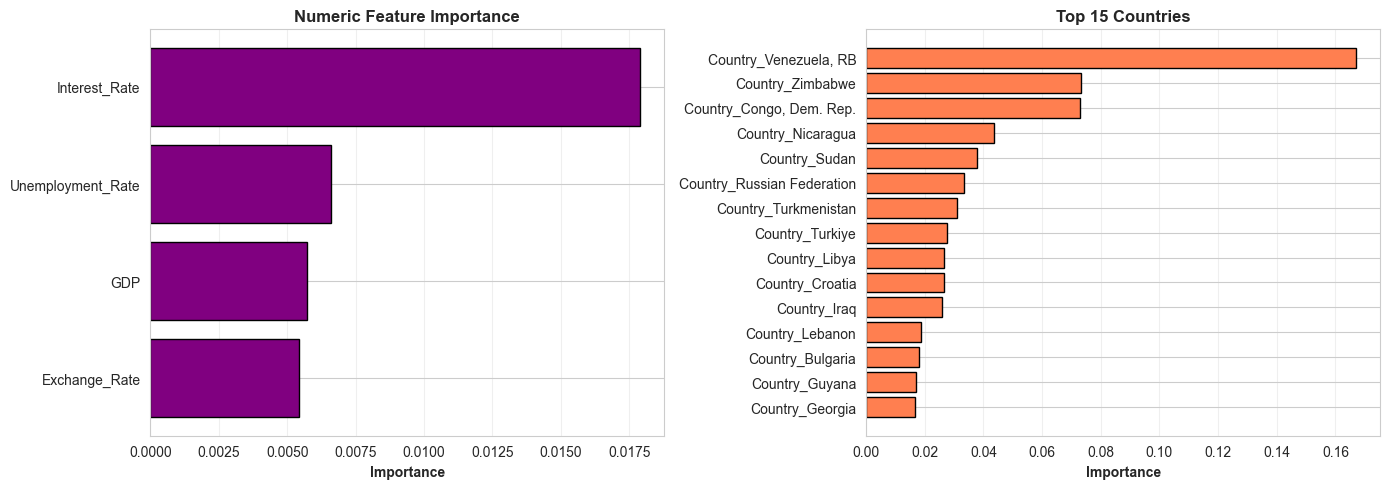


📊 Top 10 Features:


,Feature,Importance
334,"Country_Venezuela, RB",0.166870
344,Country_Zimbabwe,0.073189
61,"Country_Congo, Dem. Rep.",0.072994
218,Country_Nicaragua,0.043484
300,Country_Sudan,0.037773
267,Country_Russian Federation,0.033266
318,Country_Turkmenistan,0.031058
317,Country_Turkiye,0.027420
173,Country_Libya,0.026690
65,Country_Croatia,0.026496


In [17]:
# === Feature Importance ===

# Extract feature names
pre = best_model.named_steps["preprocessor"]
cat_ohe = pre.named_transformers_["cat"].named_steps["ohe"]

if hasattr(cat_ohe, "get_feature_names_out"):
    cat_names = list(cat_ohe.get_feature_names_out(categorical_features))
else:
    cat_names = [f"Country_{c}" for c in cat_ohe.categories_[0]]

feature_names = numeric_features + cat_names
importances = best_model.named_steps["model"].feature_importances_

# Create DataFrame
fi_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False)

# Separate numeric and country features
fi_numeric = fi_df[fi_df['Feature'].isin(numeric_features)].sort_values('Importance', ascending=True)
fi_top_countries = fi_df[~fi_df['Feature'].isin(numeric_features)].head(15).sort_values('Importance', ascending=True)

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Numeric features
axes[0].barh(fi_numeric['Feature'], fi_numeric['Importance'], color='purple', edgecolor='black')
axes[0].set_xlabel('Importance', fontweight='bold')
axes[0].set_title('Numeric Feature Importance', fontweight='bold', fontsize=12)
axes[0].grid(alpha=0.3, axis='x')

# Top countries
axes[1].barh(fi_top_countries['Feature'], fi_top_countries['Importance'], color='coral', edgecolor='black')
axes[1].set_xlabel('Importance', fontweight='bold')
axes[1].set_title('Top 15 Countries', fontweight='bold', fontsize=12)
axes[1].grid(alpha=0.3, axis='x')

plt.tight_layout()
plt.show()

print("\n📊 Top 10 Features:")
display(fi_df.head(10))

**=====Save Model & Results=====**

In [21]:
# ======================================================================
#                    SAVE MODEL & RESULTS
# ======================================================================

# Save tuned model
model_path = MODELS_DIR / "XGBoost_Base.pkl"
joblib.dump(best_model, model_path)
print(f"✅ Tuned model saved: {model_path.name}")

# Save default model
default_model_path = MODELS_DIR / "XGBoost_Base_Default.pkl"
joblib.dump(pipe_default, default_model_path)
print(f"✅ Default model saved: {default_model_path.name}")

# Create predictions DataFrame
pred_df = pd.DataFrame({
    'Country': test_df['Country'].values,
    'Year': test_df['Year'].values,
    'Actual': y_test.values,
    'Predicted': y_pred,
    'Error': residuals
})
print("\n=== Predictions Preview ===")
display(pred_df.head(10))

# Summary DataFrame
summary_df = pd.DataFrame({
    "MAE": [mae_p, mae_m, mae_default, mae],
    "RMSE": [rmse_p, rmse_m, rmse_default, rmse],
    "R²": [r2_p, r2_m, r2_default, r2],
    "MAPE%": [mape_p, mape_m, mape_default, mape_val],
    "SMAPE%": [smape_p, smape_m, smape_default, smape_val]
}, index=["Persistence", "Mean", "XGBoost_Base_Default", "XGBoost_Base_Tuned"])
print("\n=== Complete Summary ===")
display(summary_df)

# Enhanced results dictionary
results_dict = {
    # Models
    'model_tuned': best_model,
    'model_default': pipe_default,

    # Tuned metrics
    'metrics_tuned': {
        'MAE': mae,
        'RMSE': rmse,
        'R²': r2,
        'MAPE%': mape_val,
        'SMAPE%': smape_val
    },

    # Default metrics
    'metrics_default': {
        'MAE': mae_default,
        'RMSE': rmse_default,
        'R²': r2_default,
        'MAPE%': mape_default,
        'SMAPE%': smape_default
    },

    # Tuning impact
    'tuning_impact': {
        'mae_improvement': mae_improvement,
        'rmse_improvement': rmse_improvement,
        'r2_improvement': r2_improvement,
        'mae_improvement_pct': mae_improvement_pct,
        'rmse_improvement_pct': rmse_improvement_pct,
        'r2_improvement_pct': r2_improvement_pct,
        'best_params': gs.best_params_,
        'default_params': {
            'n_estimators': 100,
            'max_depth': 6,
            'learning_rate': 0.3
        }
    },

    # Other results
    'comparison': comparison,
    'tuning_comparison': tuning_comparison,
    'predictions': pred_df,
    'summary': summary_df,
    'feature_importance': fi_df
}

results_path = MODELS_DIR / "XGBoost_Base_Results.pkl"
joblib.dump(results_dict, results_path)
print(f"\n✅ Complete results saved: {results_path.name}")

# ======================================================================
#                      FINAL PERFORMANCE SUMMARY
# ======================================================================
print("\n" + "="*70)
print("    FINAL PERFORMANCE SUMMARY")
print("="*70)

print(f"\n🎯 XGBoost Base (Default - Untuned):")
print(f"   MAE:   {mae_default:.4f}")
print(f"   RMSE:  {rmse_default:.4f}")
print(f"   R²:    {r2_default:.4f}")

print(f"\n🏆 XGBoost Base (Tuned - GridSearchCV):")
print(f"   MAE:   {mae:.4f}  ({mae_improvement_pct:+.2f}%)")
print(f"   RMSE:  {rmse:.4f}  ({rmse_improvement_pct:+.2f}%)")
print(f"   R²:    {r2:.4f}  ({r2_improvement_pct:+.2f}%)")
print(f"   MAPE:  {mape_val:.2f}%")
print(f"   SMAPE: {smape_val:.2f}%")

if rmse_improvement_pct > 0:
    print(f"\n✅ Hyperparameter tuning improved RMSE by {rmse_improvement_pct:.2f}%")
else:
    print(f"\n⚠️  Hyperparameter tuning worsened RMSE by {rmse_improvement_pct:.2f}%")
    print(f"   Consider using DEFAULT model for final evaluation")

print("="*70)


✅ Tuned model saved: XGBoost_Base.pkl
✅ Default model saved: XGBoost_Base_Default.pkl

=== Predictions Preview ===


,Country,Year,Actual,Predicted,Error
0,Afghanistan,2019,5.601888,4.582603,1.019285
1,Afghanistan,2020,5.133203,4.866858,0.266345
2,Afghanistan,2021,13.712102,4.582603,9.129500
3,Afghanistan,2022,-1.562904,4.688431,-6.251336
4,Afghanistan,2023,-1.562904,4.654859,-6.217763
5,Africa,2019,4.173106,3.395987,0.777118
6,Africa,2020,4.173106,3.912843,0.260263
7,Africa,2021,4.173106,3.912843,0.260263
8,Africa,2022,4.173106,5.528283,-1.355177
9,Africa,2023,4.173106,4.856998,-0.683892



=== Complete Summary ===


,MAE,RMSE,R²,MAPE%,SMAPE%
Persistence,3.288351,15.992654,-0.221741,83.848257,46.177027
Mean,6.041782,14.498332,-0.004093,362.175969,75.421825
XGBoost_Base_Default,4.634004,12.419843,0.263165,172.672311,55.842619
XGBoost_Base_Tuned,4.667203,12.622231,0.238955,195.722853,54.312202



✅ Complete results saved: XGBoost_Base_Results.pkl

    FINAL PERFORMANCE SUMMARY

🎯 XGBoost Base (Default - Untuned):
   MAE:   4.6340
   RMSE:  12.4198
   R²:    0.2632

🏆 XGBoost Base (Tuned - GridSearchCV):
   MAE:   4.6672  (-0.72%)
   RMSE:  12.6222  (-1.63%)
   R²:    0.2390  (-9.20%)
   MAPE:  195.72%
   SMAPE: 54.31%

⚠️  Hyperparameter tuning worsened RMSE by -1.63%
   Consider using DEFAULT model for final evaluation
